# 0. Überblick und Setup
In diesem Notebook gehen wir auf das Vorlesungskapitel 2 mit den Inhalten **Lage + Streuung + Verteilungsform** ein.

In [11]:
import sys
from pathlib import Path

ROOT = Path.cwd().parent          # eine Ebene über notebooks/
if str(ROOT) not in sys.path:
    sys.path.insert(0, str(ROOT))

import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
from scipy.stats import zscore, median_abs_deviation
from src.utils_stats import iqr, trimmed_mean, tukey_fences, tukey_outliers, modified_z_score, ecdf, z_score, create_na_table
from src.utils_plots import hist_kde, box_violin, plot_ecdf, hist_with_fences, plot_qq


PATH = "../data/Taxi_final_1M.csv"
df = pd.read_csv(PATH)

print(80*"=")
print(f"Datensatz geladen: {df.shape[0]:,} Zeilen, {df.shape[1]} Spalten")
print(80*"-")
print("Erste Zeilen:", "\n", df.head(3))
print(80*"-")
print(df.describe())
print(80*"-")
print(df.info())
print(80*"=")

Datensatz geladen: 999,997 Zeilen, 17 Spalten
--------------------------------------------------------------------------------
Erste Zeilen: 
   tpep_pickup_datetime tpep_dropoff_datetime  passenger_count  trip_distance  \
0  2023-02-06 18:31:28   2023-02-06 18:41:28              1.0            2.8   
1  2023-01-13 12:22:41   2023-01-13 12:54:42              1.0            0.0   
2  2023-01-24 12:53:51   2023-01-24 13:06:09              5.0            2.3   

   PULocationID  DOLocationID  payment_type  fare_amount  extra  tip_amount  \
0           162           113             1         11.4    2.5         2.0   
1            76            61             1         22.0    0.0         0.0   
2           142            48             2         12.1    0.0         0.0   

   tolls_amount  improvement_surcharge  total_amount  congestion_surcharge  \
0           0.0                    1.0          19.9                   2.5   
1           0.0                    1.0          23.5           

# 1. Lagekennzahlen

In [ ]:
num_cols = df.select_dtypes(include="number")
lagekennzahlen_df = pd.DataFrame({
    "n": num_cols.count(),
    "Mean": num_cols.mean(),
    "Median": num_cols.median(),
    "Modus": num_cols.apply(lambda s: ", ".join(map(str, s.mode().tolist()))), # Wenn es mehrere Modi gibt diese als comma-separated Liste anzeigen
    "Trimmed Mean with 10%": num_cols.apply(lambda x: trimmed_mean(x)),
    "Min": num_cols.min(), 
    "Q1": num_cols.quantile(0.25),
    "Q3": num_cols.quantile(0.75),
    "Max": num_cols.max() 

})
format = {
    c: "{:.2f}"
    for c in lagekennzahlen_df.columns
    if pd.api.types.is_numeric_dtype(lagekennzahlen_df[c])
}

print(115*"=")
print("Überblick über fehlende Werte nach Spalte:")
display(create_na_table(num_cols))
print("\n")

print(115*"-")
print("Überblick über Lagekennzahlen nach Spalte:")
display(lagekennzahlen_df.style.format(format))
print(115*"=")

Überblick über fehlende Werte nach Spalte:


,column,n_missing,percent_missing
0,passenger_count,34408,3.4
1,trip_distance,0,0.0
2,PULocationID,0,0.0
3,DOLocationID,0,0.0
4,payment_type,0,0.0
5,fare_amount,0,0.0
6,extra,0,0.0
7,tip_amount,0,0.0
8,tolls_amount,0,0.0
9,improvement_surcharge,0,0.0




-------------------------------------------------------------------------------------------------------------------
Überblick über Lagekennzahlen nach Spalte:


,n,Mean,Median,Modus,Trimmed Mean with 10%,Min,Q1,Q3,Max
passenger_count,965589.00,1.37,1.00,1.0,1.17,0.00,1.00,1.00,8.00
trip_distance,999997.00,6.38,2.90,1.4,3.80,0.00,1.70,5.50,148560.10
PULocationID,999997.00,165.11,162.00,132,168.50,1.00,132.00,234.00,265.00
DOLocationID,999997.00,164.01,162.00,236,168.33,1.00,114.00,234.00,265.00
payment_type,999997.00,1.19,1.00,1,1.11,0.00,1.00,1.00,4.00
fare_amount,999997.00,19.46,13.50,9.3,15.89,-900.00,9.30,21.90,2449.50
extra,999997.00,1.55,1.00,0.0,1.25,-7.50,0.00,2.50,14.25
tip_amount,999997.00,3.51,2.80,0.0,2.76,-70.00,1.00,4.40,700.00
tolls_amount,999997.00,0.59,0.00,0.0,0.00,-36.05,0.00,0.00,85.00
improvement_surcharge,999997.00,0.98,1.00,1.0,1.00,-1.00,1.00,1.00,1.00


# 2. Streuungskennzahlen

In [9]:
# Klassische & robuste Streuungskennzahlen
streuungskennzahlen_df = pd.DataFrame({
    "SD": num_cols.std(),
    "Var": num_cols.var(),
    "IQR": num_cols.quantile(0.75) - num_cols.quantile(0.25),
    "MAD": num_cols.apply(lambda x: median_abs_deviation(x)),
    "Range": num_cols.max() - num_cols.min()
})
display(streuungskennzahlen_df.style.format("{:,.2f}"))

,SD,Var,IQR,MAD,Range
passenger_count,0.89,0.80,0.00,nan,8.00
trip_distance,218.07,"47,555.68",3.80,1.50,"148,560.10"
PULocationID,63.99,"4,094.37",102.00,62.00,264.00
DOLocationID,69.77,"4,867.70",120.00,68.00,264.00
payment_type,0.56,0.31,0.00,0.00,4.00
fare_amount,19.00,361.11,12.60,5.60,"3,349.50"
extra,1.84,3.39,2.50,1.00,21.75
tip_amount,4.12,17.00,3.40,1.80,770.00
tolls_amount,2.19,4.77,0.00,0.00,121.05
improvement_surcharge,0.20,0.04,0.00,0.00,2.00


# 3. Ausreißer erkennen (Diagnose)

In [10]:
def create_outlier_table(df):
    results = []

    for col in num_cols.columns:
        s = num_cols[col].astype(float)

        z_mask = z_score(s)

        modz_mask = modified_z_score(s)
        tukey_mask = tukey_outliers(s)

        results.append({
            "Spalte": col,
            "Z-Score": int(z_mask.sum()),
            "Modified Z-Score": int(modz_mask.sum()),
            "Tukey IQR": int(tukey_mask.sum())
        })

    outlier_table = pd.DataFrame(results).set_index("Spalte")
    display(outlier_table)

create_outlier_table(num_cols)

/opt/anaconda3/lib/python3.12/site-packages/numpy/core/_methods.py:173: RuntimeWarning: invalid value encountered in subtract
  x = asanyarray(arr - arrmean)


,Z-Score,Modified Z-Score,Tukey IQR
Spalte,,,
passenger_count,21021,0,240076
trip_distance,24,136426,130715
PULocationID,0,0,0
DOLocationID,0,0,0
payment_type,19319,0,221690
fare_amount,12118,101557,108910
extra,16991,18729,18294
tip_amount,25905,47659,76499
tolls_amount,6187,0,81129


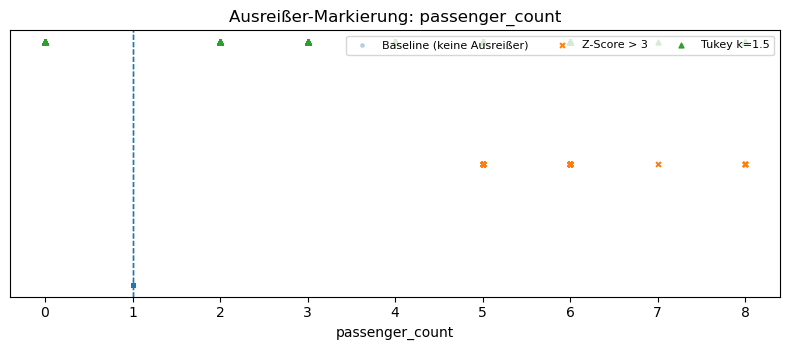

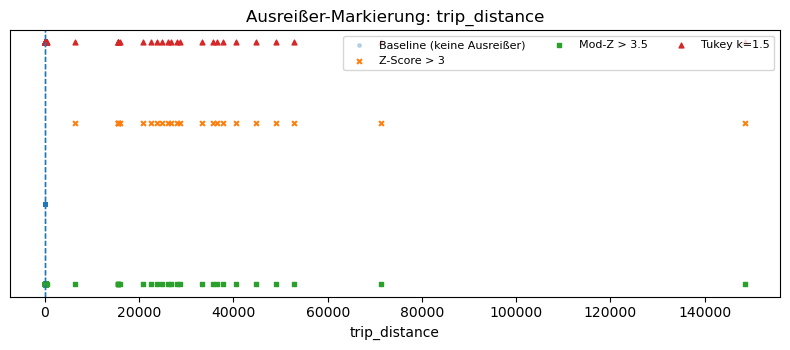

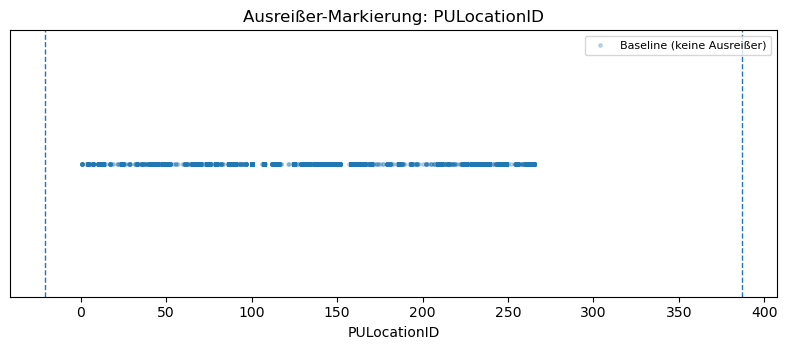

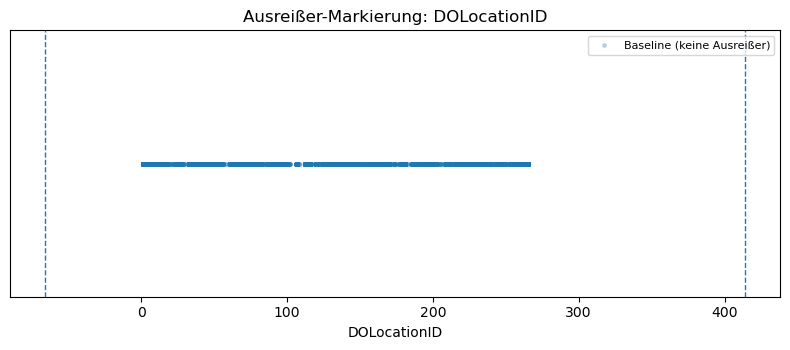

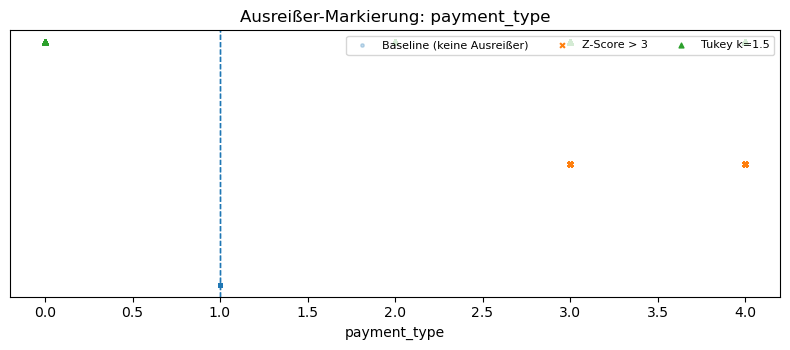

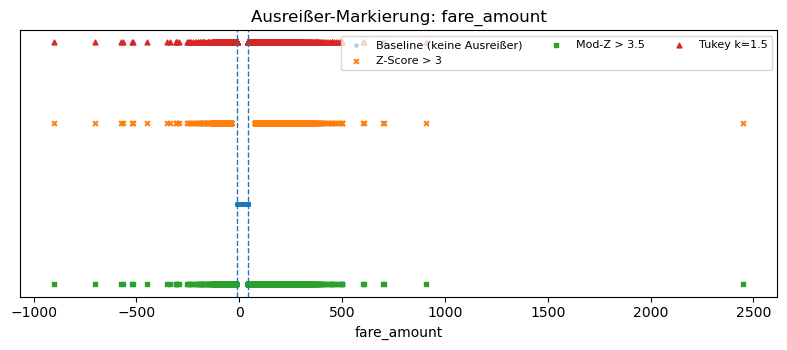

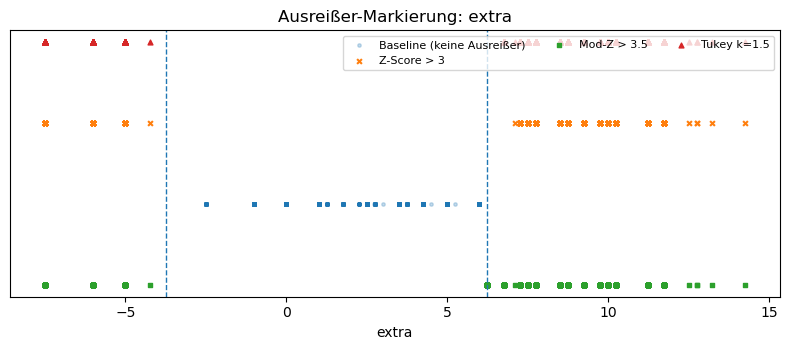

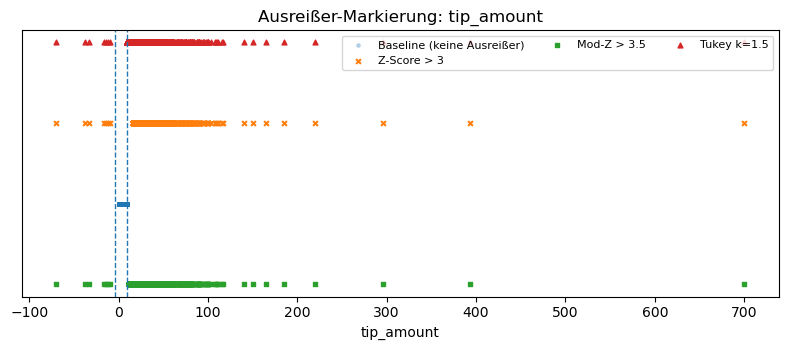

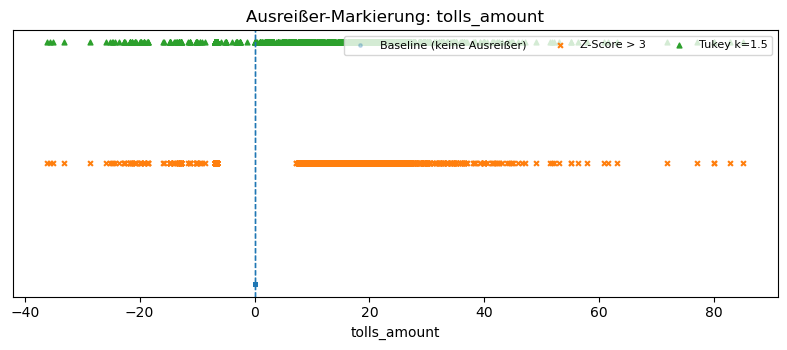

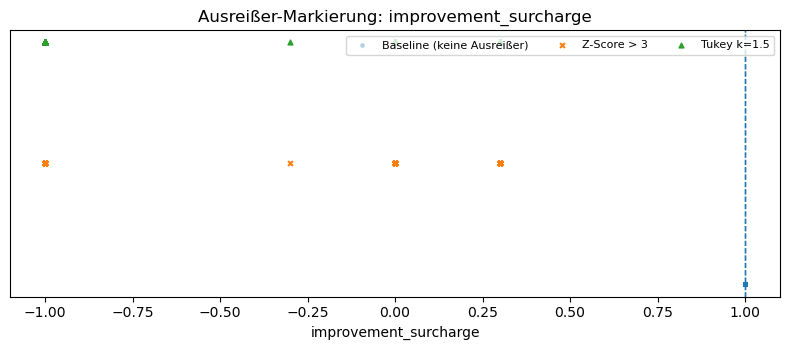

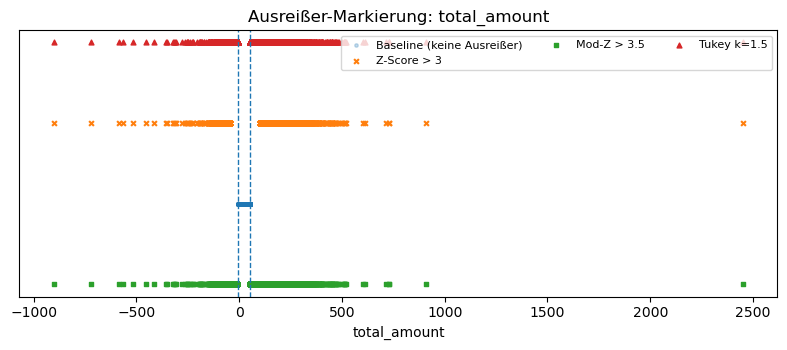

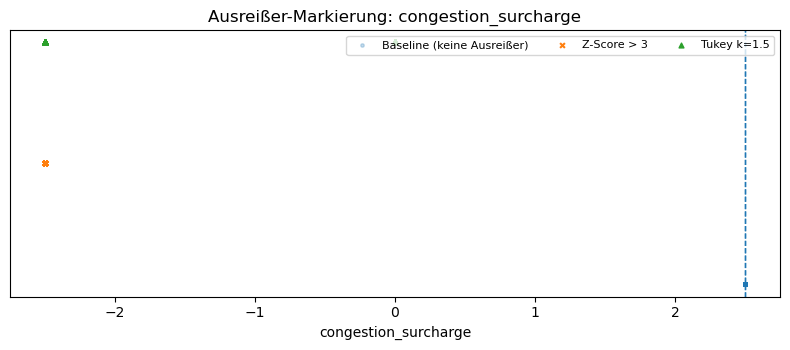

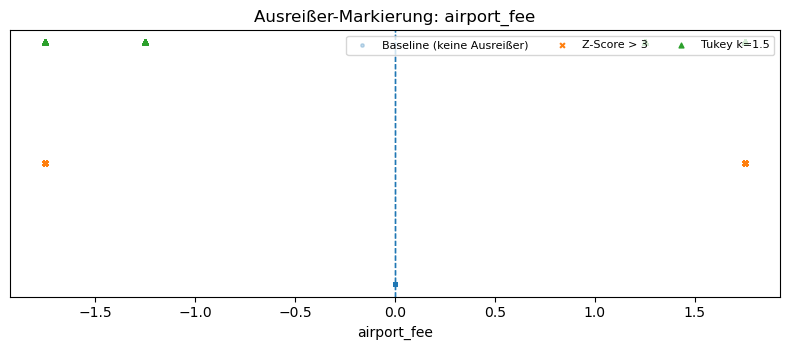

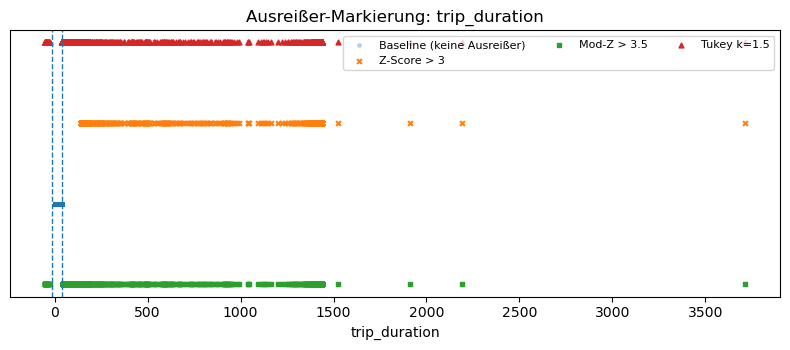

/opt/anaconda3/lib/python3.12/site-packages/numpy/core/_methods.py:173: RuntimeWarning: invalid value encountered in subtract
  x = asanyarray(arr - arrmean)
/opt/anaconda3/lib/python3.12/site-packages/scipy/stats/_stats_py.py:3100: RuntimeWarning: invalid value encountered in subtract
  z = (scores - mn) / std


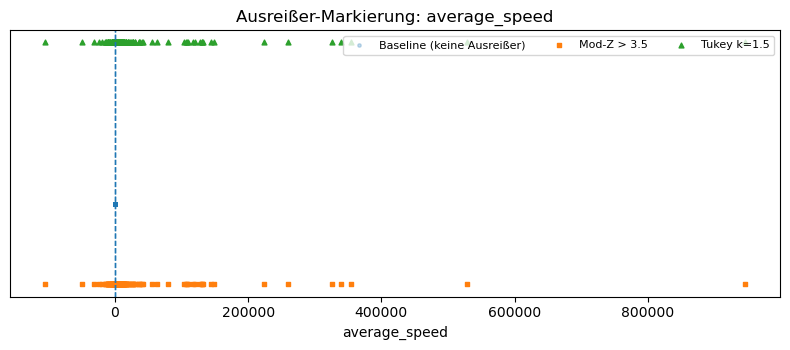

In [23]:
max_baseline_points = 40000  # anpassen bei Bedarf
for col in num_cols.columns:
    s = num_cols[col].astype(float)
    x = s.to_numpy(copy=True)

    # --- Masken berechnen (vektorisiert) ---
    # Klassischer Z-Score (NaNs ignorieren)
    z = zscore(x, nan_policy='omit')
    # Modified Z-Score (mit unskalierter MAD)
    med = np.nanmedian(x)
    mad = median_abs_deviation(x, scale=1.0, nan_policy='omit')  # unskaliert!
    modz = 0.6744897501960817 * (x - med) / (mad if mad != 0 else np.nan)

    # Tukey-Fences
    q1, q3 = np.nanpercentile(x, [25, 75])
    iqr = q3 - q1
    lo, hi = q1 - 1.5 * iqr, q3 + 1.5 * iqr

    mask_z = np.abs(z) > 3
    mask_modz  = np.abs(modz) > 3.5
    mask_tukey = (x < lo) | (x > hi)

    # --- Basis-Rug/Scatter (ohne alles lahmzulegen) ---
    n = x.size
    idx_all = np.arange(n)

    mask_any = mask_z | mask_modz | mask_tukey
    non_out_idx = idx_all[~mask_any]

    if n > max_baseline_points and non_out_idx.size > max_baseline_points:
        rng = np.random.default_rng(42)
        baseline_idx = rng.choice(non_out_idx, size=max_baseline_points, replace=False)
    else:
        baseline_idx = non_out_idx

    # y-Achse ist nur eine "Jitter-Linie", damit man Punkte sieht
    y0 = np.zeros(n, dtype=float)

    plt.figure(figsize=(8, 3.6))
    # baseline
    if baseline_idx.size:
        plt.scatter(x[baseline_idx], y0[baseline_idx], s=6, alpha=0.25, label="Baseline (keine Ausreißer)")

    # Outlier-Layer (verschiedene Marker, kleine Offsets für bessere Lesbarkeit)
    if mask_z.any():
        plt.scatter(x[mask_z], y0[mask_z] + 0.06, s=12, marker='x', label=f"Z-Score > {3}")
    if mask_modz.any():
        plt.scatter(x[mask_modz], y0[mask_modz] - 0.06, s=12, marker='s', label=f"Mod-Z > {3.5}")
    if mask_tukey.any():
        plt.scatter(x[mask_tukey], y0[mask_tukey] + 0.12, s=12, marker='^', label=f"Tukey k={1.5}")

    # Tukey-Grenzen als Linien
    if np.isfinite(lo): plt.axvline(lo, linestyle='--', linewidth=1)
    if np.isfinite(hi): plt.axvline(hi, linestyle='--', linewidth=1)

    # Layout
    plt.yticks([])  # y-Achse ist nur Träger
    plt.xlabel(col)
    plt.title(f"Ausreißer-Markierung: {col}")
    plt.legend(loc="upper right", ncol=3, fontsize=8, frameon=True)
    plt.tight_layout()
    plt.show()

# 4. Verteilungsform (Histogramm + KDE)

In [ ]:
for v,u in [("trip_distance","miles"),
            ("trip_duration","min"),
            ("average_speed","mph"),
            ("fare_amount","USD"),
            ("tip_amount","USD"),
            ("total_amount","USD")]:
    hist_kde(df[v], title=v, unit=u, bw_adjust_list=(0.7, 1.0, 1.8))
    box_violin(df[v], title=v)
    plot_ecdf(df[v], title=v, unit=u)